### Data Challenge MDI341, Student : David Tang ; Ranked 9th/62 with a score of 0.86648417515

# Introduction

#### Authors :  Pavlo Mozharovskyi and Umut Şimşekli


The goal of this challenge is to develop a binary classification system which tries to detect if an **image contains some property not** (you can try to discover what these "properties" are).    

As opposed to the previous challenge, we will follow a different procedure in this challenge. The challenge will have **two phases**. Please read the below information carefully.  

**In the first phase** of the challenge, you will be provided a **training dataset** which contains the **raw images** and their corresponding **labels**. We will also provide you a **validation dataset**, which only contains the **raw images**. The labes of the validation set will not be provided. In this phase, you will train your system based on this data and the ranking in the challenge webpage will be based on your score obtained on the validation data.

**The second phase** of the challenge will start only **a few hours (at most one day) before the deadline**. Within this period, we will provide you the **test set**. You will need to run the algorithm that you developed on the first phase on this dataset and submit your predictions to the challenge webpage. Your **final ranks** will be determined on this dataset. Note that **this phase will only last a few hours**, which means that you will not be able to tune your algorithm on this dataset.



## The properties of the dataset:

**Training data:**

The training set contains raw images and their labels. There are 116157 images in this dataset. Each image is of size 56 x 56 x 3 (the last dimension encodes the color information: red-green-blue). For each image there is a label, either 0 or 1.

**Validation data:**

The validation set only contains raw images. There are 27013 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided. Within the first phase, your ranks will be calculated based on this dataset. 


**Test data:**

The test set only contains raw images as well. There will be 59429 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. Your final ranks will be calculated based on this dataset. 



### The performance criterion

As you will observe after examining the dataset, the data is highly unbalanced. Therefore, we choose a suitable criterion for evaluation: the performance criterion will be the average accuracy for each class, which is computed as follows: 


$\text{score} = \frac1{2} \Biggl( \frac1{N_0}\sum_{i=1}^{N} (1-y_i)(1-\hat{y}_i) + \frac1{N_1}\sum_{i=1}^{N} y_i \hat{y}_i \Biggr),$

where $N$ denotes the total number elements of the dataset (it could be the training, validation or test set), $N_0$ denotes the number of elements whose labels are $0$, $N_1$ similarly denotes the number of elements whose labels are $1$, $y_i$ denotes the true label of the data sample $i$, and $\hat{y}_i$ denotes the predicted label for the data sample $i$. 


As an example, if all your predictions are 0, then your score will be 50%. The higher the score, the better the performance.



# Training Data

Images: https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw

Labels: https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt


# Validation Data

Images: https://www.dropbox.com/s/qonk627t2557utz/db_val.raw


______________________________________________________________________________________________


### Importing datasets when using Google Colab

In [1]:
# Download datasets on google drive for Google Colab :
'''
from google.colab import drive
drive.mount('/content/gdrive')
!wget https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw?dl=1
!wget https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt?dl=1
# !wget https://www.dropbox.com/s/qonk627t2557utz/db_val.raw?dl=1
!wget https://www.dropbox.com/s/mnido8qbwmbi79h/db_test.raw

!mv db_train.raw?dl=1 db_train.raw
# !mv db_val.raw?dl=1 db_val.raw
!mv label_2019_train.txt?dl=1 label_2019_train.txt
!mv db_test.raw?dl=1 db_test.raw
'''

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
--2019-03-31 21:57:46--  https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/486li09u91zyjdm/db_train.raw [following]
--2019-03-31 21:57:46--  https://www.dropbox.com/s/dl/486li09u91zyjdm/db_train.raw
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f92be747fbb7090de1c10e2a5.dl.dropboxusercontent.com/cd/0/get/AeIhBPF2W9vRAqIHAJ0BdN-5LRS_OR97qEjxhPyxcml8tjktEH_VfyyDHwFWoiCruq8bavdYEv-Zswr4s793zJGgw3bHuvZxY3And8hhNa7wqlzuERCEZaP4AWMdpfsPLxw/file?dl=1# [following]
--2019-03-31 21:57:46--  https://uc9f92be747fbb7090de1c10e2a5.dl.dropboxuserco

### This address identifies the TPU we'll use when configuring TensorFlow.

In [ ]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

## Importing libraries

In [35]:
%matplotlib inline

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
sns.set(style="darkgrid") # seaborn plot style
import warnings
warnings.filterwarnings("ignore")
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold

# tensorflow.keras modules
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Conv2DTranspose, Conv2D
from tensorflow.keras.layers import Flatten, Dense, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

## Loading and investigating the data

In [12]:
train_images_fname = 'db_train.raw'
train_labels_fname = 'label_2019_train.txt'

# val_images_fname    = 'db_val.raw'
test_images_fname = 'db_test.raw'


# number of images
num_train_images = 116157
num_valid_images = 27013
num_test_images = 59429


# size of the images 56*56 pixels in gray levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_images_data = train_images_data.reshape(num_train_images, image_dim)
'''    
with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    val_images_data = val_images_data.reshape(num_valid_images, image_dim) 
'''
with open(test_images_fname, 'rb') as f:
    test_images_data = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.float32)
    test_images_data = test_images_data.reshape(num_test_images, image_dim) 

__Dataset size__

In [5]:
print("Shape of training set :", train_images_data.shape)
print("Shape of training set labels :", train_images_label.shape)
print("Shape of validation set :", val_images_data.shape)
print("Shape of test set :", test_images_data.shape)

Shape of training set : (116157, 9408)
Shape of training set labels : (116157,)
Shape of validation set : (27013, 9408)
Shape of test set : (59429, 9408)


__Let's look at some images:__

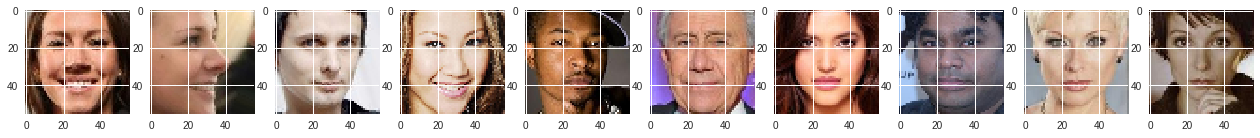

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(22, 8))

for i, ax in enumerate(axes):
    ax.imshow(train_images_data[i].reshape(56, 56,3).astype(np.uint8))

__Images with label 1__

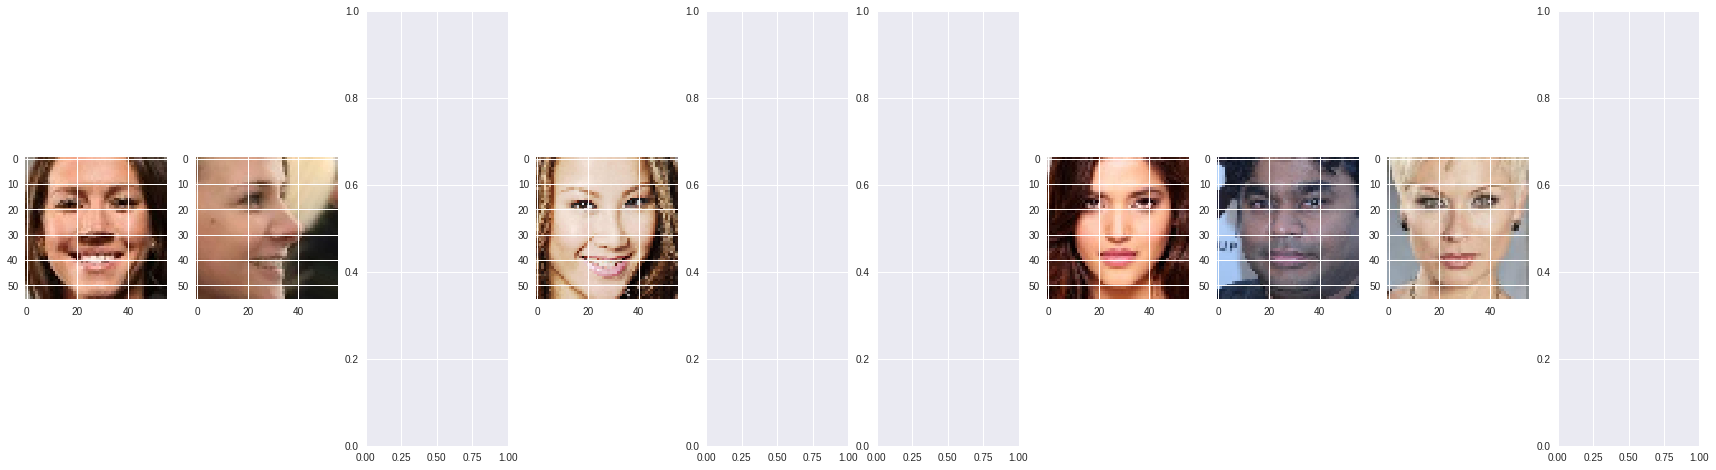

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 8))

for i, ax in enumerate(axes):
    if train_images_label[i] == 1.0:
        ax.imshow(train_images_data[i].reshape(56, 56, 3).astype(np.uint8))

__Images with label 0__

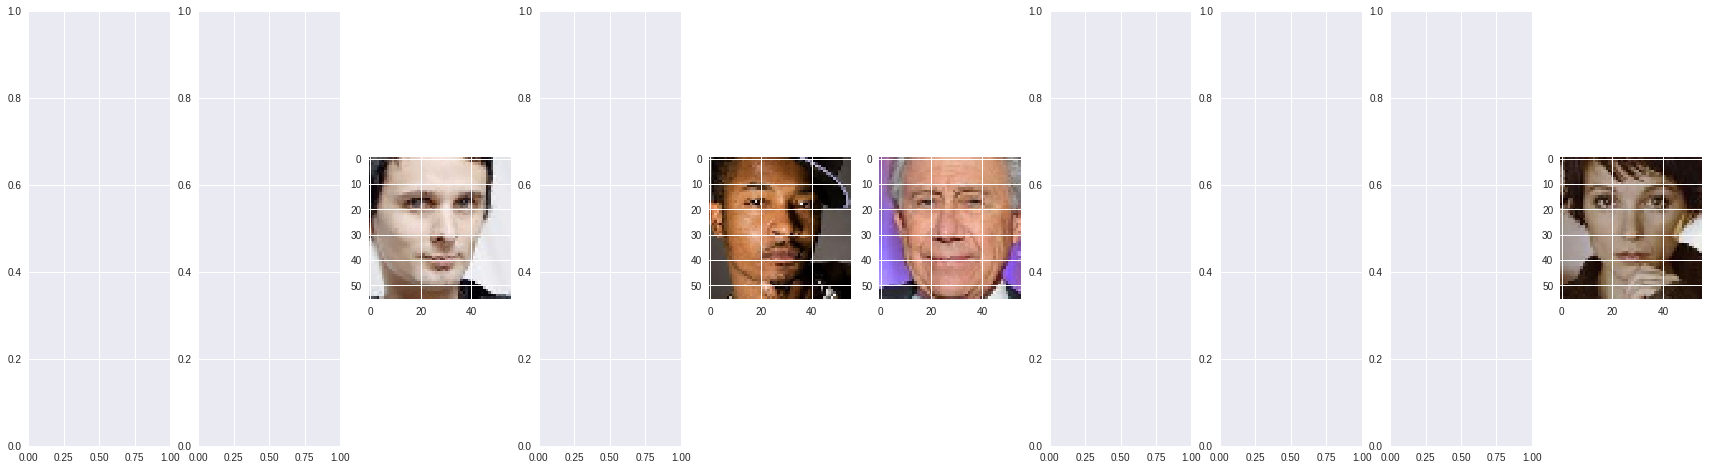

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 8))

for i, ax in enumerate(axes):
    if train_images_label[i] == 0.0:
        ax.imshow(train_images_data[i].reshape(56, 56, 3).astype(np.uint8))

### Checking if there are any duplicated rows (images) when concatenating training and validation sets

In [0]:
training_df = pd.DataFrame(train_images_data)
training_label_df = pd.DataFrame(train_images_label)
validation_df = pd.DataFrame(val_images_data)

In [0]:
# df = pd.concat([training_df, validation_df])
# len(df)
# len(df.drop_duplicates(keep=False))

__I did not re-run the above lines since it was consuming too much ram.  
But when I ran these lines the first time, I have noticed that some images contained in the validation set were also in the training set__

__Balance in the training set__  

In [0]:
print(training_label_df[0].value_counts(), "\n") 
print("% of training set labeled 1 : {}% \n% of training set labeled 0 : {}% ".format(
    round(training_label_df[0].value_counts()[0] / train_images_data.shape[0],2)*100, 
    round(training_label_df[0].value_counts()[1] / train_images_data.shape[0],2)*100))

1.0    68888
0.0    47269
Name: 0, dtype: int64 

% of training set labeled 1 : 41.0% 
% of training set labeled 0 : 59.0% 


## Reshaping Images format & Normalization

In [13]:
with open(train_images_fname, 'rb') as f:
    X_train = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    X_train = train_images_data.reshape(116157, 56, 56, 3)

#### Entering into the second phase of the chalenge, I won't be using this validation set anymore and will whether focus on the validation set I build from a train test split from the training set

In [10]:
'''
with open(val_images_fname, 'rb') as f:
    X_valid = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    X_valid = val_images_data.reshape(27013, 56, 56, 3)
'''

"\nEntering into the second phase of the chalenge, I won't be using this validation set anymore, and will focus on the validation set I build from a train test split from the training set\nwith open(val_images_fname, 'rb') as f:\n    X_valid = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)\n    X_valid = val_images_data.reshape(27013, 56, 56, 3)\n"

In [14]:
with open(test_images_fname, 'rb') as f:
    X_test = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.float32)
    X_test = test_images_data.reshape(59429, 56, 56, 3)

In [15]:
# Normalization of X_train and X_test
X_train = X_train/255
X_test = X_test/255

In [16]:
y_train = train_images_label
y_train = y_train.reshape(116157,1)
# y_test 

In [17]:
# Checking shapes
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 116157
number of test examples = 59429
X_train shape: (116157, 56, 56, 3)
y_train shape: (116157, 1)
X_test shape: (59429, 56, 56, 3)


## Splitting training set into a train set and a test set

In [18]:
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(
  X_train, y_train, test_size = 0.1, random_state=42)

In [19]:
# Checking shapes
print ("X_train_bis shape: " + str(X_train_bis.shape))
print ("y_train_bis shape: " + str(y_train_bis.shape))
print ("X_test_bis shape: " + str(X_test_bis.shape))
print ("y_test_bis shape: " + str(y_test_bis.shape))

X_train_bis shape: (104541, 56, 56, 3)
y_train_bis shape: (104541, 1)
X_test_bis shape: (11616, 56, 56, 3)
y_test_bis shape: (11616, 1)


## Image augmentation with Keras (failed, not enough dedicated ram on colab)

In [0]:
# datagen = ImageDataGenerator(horizontal_flip = True)
# datagen.fit(X_train)

__I have tried various architectures on different notebooks, So I decided to gather only a few of my attempts and re-run them on this unique jupyter.  
In the first model in this notebook, you will find a model with 3 convolutional layers.  
Also, I added dropout as well as L2 regularization to avoid overfitting on my training set.__

## Building a first model

In [36]:
K.clear_session()

# L2 regularization
weight_decay = 1e-4

def third_model(input_shape = (56, 56, 3)):
  
    # placeholder as a tensor
    X_input = Input(input_shape)

    # Paddings
    X = ZeroPadding2D((3, 3))(X_input)
    
    # 1st Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-4), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    # Dropout
    X = Dropout(0.2, name='drop_out0')(X) 
    
    # 2nd Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    # Dropout
    X = Dropout(0.3, name='drop_out1')(X)

    # 3rd Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    # Dropout
    X = Dropout(0.4, name='drop_out2')(X)
    
    # Flattening and Fully connected
    X = Flatten()(X)
    X = Dense(100, activation='relu', name='fc0')(X)
    X = Dropout(0.25, name='drop_out3')(X)
    X = Dense(50, activation='relu', name='fc1')(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)

    # Create Keras model instance, we'll use this instance to train/test the model
    model = Model(inputs = X_input, outputs = X, name='third_model')
    
    return model

In [37]:
third_model = third_model()

#### Model architecture

In [38]:
print(third_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 62, 62, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 60, 32)        896       
_________________________________________________________________
bn0 (BatchNormalizationV1)   (None, 60, 60, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
drop_out0 (Dropout)          (None, 30, 30, 32)        0         
__________

In [0]:
third_model = tf.contrib.tpu.keras_to_tpu_model(
    third_model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.23.63.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18041346840966150545)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16417346183383628006)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8771599392081736075)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4571437692135299796)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14343562212370959224)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

#### Default hyperparameters of Adam Optimizer  
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  
For now I won't try to tune learning rate in the Adam optimizer

In [39]:
third_model.compile(optimizer = "Adam",
                     loss = "binary_crossentropy",
                     metrics = ["accuracy"])

__In my various jupyter notebooks, I have tried tuning different batchsize, as well as the number of epochs, the best hyperparamers that came out are the ones bellow__

#### Fitting the model to the validation set

In [40]:
# Fitting the CNN with 35 epochs and batchsize = 128
third_model.fit(x = X_train_bis, 
                 y = y_train_bis,
                 epochs = 35,
                 batch_size = 128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
104541/104541 [==============================] - 40s 379us/sample - loss: 0.5565 - acc: 0.6932
Epoch 2/35
104541/104541 [==============================] - 27s 257us/sample - loss: 0.4677 - acc: 0.7578
Epoch 3/35
104541/104541 [==============================] - 27s 254us/sample - loss: 0.4464 - acc: 0.7735
Epoch 4/35
104541/104541 [==============================] - 27s 254us/sample - loss: 0.4352 - acc: 0.7821
Epoch 5/35
104541/104541 [==============================] - 27s 255us/sample - loss: 0.4263 - acc: 0.7891
Epoch 6/35
104541/104541 [==============================] - 27s 255us/sample - loss: 0.4195 - acc: 0.7936
Epoch 7/35
104541/104541 [==============================] - 27s 254us/sample - loss: 0.4130 - acc: 0.8020 - 
Epoch 8/35
104541/104541 [==============================] - 27s 254us/sample - loss: 0.4061 - acc: 0.8083 - loss: 0.4063 - acc:
Epoch 9/35
104541/104541 [==============================] - 27s 255us/sample - 

#### Fitting the model to the entire training set

In [41]:
# Fitting the CNN with 35 epochs and batchsize = 128 with the additional MLP layers
# BEST SO FAR
third_model.fit(x = X_train, 
                 y = y_train,
                 epochs = 35,
                 batch_size = 128)

Epoch 1/35
116157/116157 [==============================] - 74s 638us/sample - loss: 0.3678 - acc: 0.8459
Epoch 2/35
116157/116157 [==============================] - 30s 257us/sample - loss: 0.3669 - acc: 0.8467 - los
Epoch 3/35
116157/116157 [==============================] - 30s 256us/sample - loss: 0.3682 - acc: 0.8460
Epoch 4/35
116157/116157 [==============================] - 29s 253us/sample - loss: 0.3654 - acc: 0.8475
Epoch 5/35
116157/116157 [==============================] - 30s 254us/sample - loss: 0.3679 - acc: 0.8458
Epoch 6/35
116157/116157 [==============================] - 30s 254us/sample - loss: 0.3674 - acc: 0.8455
Epoch 7/35
116157/116157 [==============================] - 30s 255us/sample - loss: 0.3666 - acc: 0.8476
Epoch 8/35
116157/116157 [==============================] - 29s 253us/sample - loss: 0.3649 - acc: 0.8482
Epoch 9/35
116157/116157 [==============================] - 29s 254us/sample - loss: 0.3670 - acc: 0.8472
Epoch 10/35
116157/116157 [=============

KeyboardInterrupt: 

#### Accuracy score on the validation set

In [0]:
# Third_model with batchsize = 128 and epochs = 35
# Generate the prediction and check accuracy score on the test set from the train_test_split
y_pred_bis = third_model.predict(X_test_bis)

for i in range(0,11616):
    if y_pred_bis[i] >= 0.5:
        y_pred_bis[i] = 1
    else:
        y_pred_bis[i]=0

# Accuracy score on the validation set
from sklearn.metrics import accuracy_score 
accuracy = accuracy_score(y_pred_bis, y_test_bis)
print(accuracy)

0.8397899449035813


In [ ]:
### Generating the prediction

y_pred = third_model.predict(X_test)

for i in range(0,59429):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0
        
# Generating a file to be submitted to the server        
np.savetxt("predictions.txt", y_pred, fmt="%d")

# from google.colab import files
# files.download('third_model_10epochs_128batchsize_vf_v2.txt')

### Model selection : K-Fold Cross Validation failed, too computationnally expensive on Google Colab

In [0]:
# Model Selection : K-Fold Cross Validation

'''

K.clear_session()

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cvscores = []

for train, test in kfold.split(X_train, y_train):
  # third model used before
  third_model = Sequential()
    # Paddings
  third_model.add(ZeroPadding2D(3,input_shape=(56, 56, 3)))
  # 1st Convolution layer + L2 regularization +Batch Normalization + RELU activation
  third_model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-4), strides = (1, 1), name = 'conv0'))
  third_model.add(BatchNormalization(axis = 3, name = 'bn0'))
  third_model.add(Activation('relu'))
    # Max Pooling of size 2
  third_model.add(MaxPooling2D((2, 2), name='max_pool0'))
  # Dropout
  third_model.add(Dropout(0.2, name='drop_out0'))
    # 2nd Convolution layer + L2 regularization +Batch Normalization + RELU activation
  third_model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-4), strides = (1, 1), name = 'conv1'))
  third_model.add(BatchNormalization(axis = 3, name = 'bn1'))
  third_model.add(Activation('relu'))
    # Max Pooling of size 2
  third_model.add(MaxPooling2D((2, 2), name='max_pool1'))
    # Dropout
  third_model.add(Dropout(0.3, name='drop_out1'))
    # 3rd Convolution layer + L2 regularization +Batch Normalization + RELU activation
  third_model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(1e-4), strides = (1, 1), name = 'conv2'))
  third_model.add(BatchNormalization(axis = 3, name = 'bn2'))
  third_model.add(Activation('relu'))
    # Max Pooling of size 2
  third_model.add(MaxPooling2D((2, 2), name='max_pool2'))
    # Dropout
  third_model.add(Dropout(0.4, name='drop_out2'))
    # Flattening and Fully connected layers
  third_model.add(Flatten())
  third_model.add(Dense(100, activation='relu', name='fc0'))
  third_model.add(Dropout(0.25, name='drop_out3'))
  third_model.add(Dense(50, activation='relu', name='fc1'))
  third_model.add(Dense(1, activation='sigmoid', name='fc2'))
  
  # Using TPU
  third_model = tf.contrib.tpu.keras_to_tpu_model(third_model, strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  # Compiling the model
  third_model.compile(optimizer = "Adam",
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])
  
  # Fitting the CNN with 25 epochs and batchsize = 128 with the additional MLP layers
  third_model.fit(x = X_train[train], 
                  y = y_train[train],
                  epochs = 25,
                  batch_size = 128)
  
  # Because I have issues with my batch_size when doing the predict method with the tpu_model, I'm using the CPU for the prediction
  third_model = third_model.sync_to_cpu()

  # Evaluating the model
  scores = third_model.evaluate(X_train[test], y_train[test])
  print("%s: %.2f%%" % (third_model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  '''

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.81.109.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17895138681079270622)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2373815479875226713)
INFO:tensorflow:*** Available Device: _DeviceAt

## Building a second model

__This model is the one who performed the best. In the second model, I decided to make my model more complex/deeper, since I believed my previous models were underfitting a bit. My goal was to reduce the bias through increasing the training accuracy.__

In [61]:
K.clear_session()

# L2 regularization
weight_decay = 1e-4

def sixth_model(input_shape = (56, 56, 3)):
  
    # placeholder as a tensor
    X_input = Input(input_shape)

    # Paddings
    X = ZeroPadding2D((3, 3))(X_input)
    
    # 2 Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-4), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    # Dropout
    X = Dropout(0.2, name='drop_out0')(X) 
    
    # 2 Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    # Dropout
    X = Dropout(0.3, name='drop_out1')(X)

    # 1 Convolution layer + L2 regularization +Batch Normalization + RELU activation
    X = Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), strides = (1, 1), name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    # Max Pooling of size 2
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    # Dropout
    X = Dropout(0.4, name='drop_out2')(X)
    
    # Flattening and Fully connected
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc0')(X)
    X = Dropout(0.5, name='drop_out3')(X) # A higher dropout allowed to perform better
    X = Dense(50, activation='relu', name='fc1')(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)
    
    # Create Keras model instance, we'll use this instance to train/test the model
    model = Model(inputs = X_input, outputs = X, name='sixth_model')
    
    return model

#### Model architecture

In [62]:
sixth_model = sixth_model()
print(sixth_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 62, 62, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 60, 32)        896       
_________________________________________________________________
bn0 (BatchNormalizationV1)   (None, 60, 60, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        9248      
_________________________________________________________________
bn1 (BatchNormalizationV1)   (None, 58, 58, 32)        128       
__________

#### Tuning learning rate and decay in Adam optimizer when compiling the model

In [63]:
sixth_model.compile(optimizer = Adam(lr=0.0001, decay=1e-6),
                     loss = "binary_crossentropy",
                     metrics = ["accuracy"])

#### Fitting the model to the validation set of the train test split and see how accuracy and loss behave on the training and validation sets

In [64]:
# Fitting the CNN with 35 epochs and batchsize = 128 
history = sixth_model.fit(x = X_train, y = y_train, validation_split = 0.1,
                          epochs = 35,
                          batch_size = 128)

Train on 104541 samples, validate on 11616 samples
Epoch 1/35
104541/104541 [==============================] - 44s 426us/sample - loss: 0.6606 - acc: 0.6319 - val_loss: 0.5695 - val_acc: 0.6977
Epoch 2/35
104541/104541 [==============================] - 43s 413us/sample - loss: 0.5525 - acc: 0.7012 - val_loss: 0.5099 - val_acc: 0.7385
Epoch 3/35
104541/104541 [==============================] - 43s 415us/sample - loss: 0.5046 - acc: 0.7351 - val_loss: 0.5202 - val_acc: 0.7497
Epoch 4/35
104541/104541 [==============================] - 43s 414us/sample - loss: 0.4718 - acc: 0.7664 - val_loss: 0.4364 - val_acc: 0.8011
Epoch 5/35
104541/104541 [==============================] - 43s 414us/sample - loss: 0.4478 - acc: 0.7856 - val_loss: 0.4405 - val_acc: 0.7950
Epoch 6/35
104541/104541 [==============================] - 44s 420us/sample - loss: 0.4299 - acc: 0.7982 - val_loss: 0.4199 - val_acc: 0.8112
Epoch 7/35
104541/104541 [==============================] - 43s 413us/sample - loss: 0.4184

In [65]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


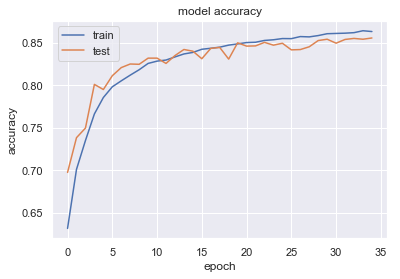

In [66]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__From the accuracy plot, we can guess that the model is trained enough since both trends for accuracy on the 2 datasets are starting to flatten. Besides, the model is also starting to over-learned on the training set__

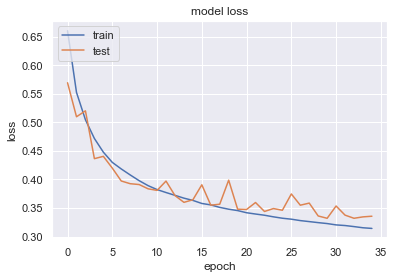

In [67]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__From the loss plot, we notice that the model performance is quite similar on the both training and validation sets.__

#### Fitting the model to the entire training set

In [43]:
# Fitting the CNN with 35 epochs and batchsize = 128 
sixth_model.fit(x = X_train, 
                 y = y_train,
                 epochs = 35,
                 batch_size = 128)

Epoch 1/35
116157/116157 [==============================] - 47s 403us/sample - loss: 0.6549 - acc: 0.6324 - loss: 0.656
Epoch 2/35
116157/116157 [==============================] - 45s 392us/sample - loss: 0.5475 - acc: 0.7084
Epoch 3/35
116157/116157 [==============================] - 46s 395us/sample - loss: 0.4936 - acc: 0.7439
Epoch 4/35
116157/116157 [==============================] - 46s 393us/sample - loss: 0.4535 - acc: 0.7803
Epoch 5/35
116157/116157 [==============================] - 46s 393us/sample - loss: 0.4281 - acc: 0.8000
Epoch 6/35
116157/116157 [==============================] - 46s 394us/sample - loss: 0.4123 - acc: 0.8092
Epoch 7/35
116157/116157 [==============================] - 46s 394us/sample - loss: 0.4022 - acc: 0.8157
Epoch 8/35
116157/116157 [==============================] - 46s 393us/sample - loss: 0.3912 - acc: 0.8229
Epoch 9/35
116157/116157 [==============================] - 45s 385us/sample - loss: 0.3845 - acc: 0.8273TA: 1s - loss: 0.3
Epoch 10/35
11

In [75]:
# Generate the prediction

y_pred = sixth_model.predict(X_test)

for i in range(0,59429):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

# Generating a file to be submitted to the server        
np.savetxt("predictions.txt", y_pred, fmt="%d")
# from google.colab import files
# files.download('fourth_model_25epochs_128batchsize.txt')

## Building a third model : much deeper architecture using skip connections (ResNet50)

__In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers. This allows to build much deeper architecture, since deep architecture are hard to train due to the vanishing gradient problem.__

In [16]:
def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

In [17]:
# The identity block : block that has no convolution layer at shortcut

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [18]:
# The convolutional block : the bloc that has a convolution layer at shortcut

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(F3,(1, 1), strides = (1,1), name = conv_name_base + '2c',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [19]:
# ResNet50 Architecture

K.clear_session()

def ResNet50(input_shape = (64, 64, 3), classes = 1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2,2),name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [20]:
ResNet50 = ResNet50(input_shape = (56, 56, 3))

In [21]:
print(ResNet50.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 62, 62, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 28, 28, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
ResNet50 = tf.contrib.tpu.keras_to_tpu_model(
    ResNet50,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.120.2.50:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8657125785420059506)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2437217439065190928)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17195868427289005796)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1,

In [22]:
ResNet50.compile(optimizer = "Adam",
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])

#### Fitting the ResNet50 on the validation set of train test split

In [ ]:
# Fitting the ResNet50 with 3 epochs and batchsize = 128
ResNet50.fit(x = X_train_bis, 
             y = y_train_bis,
             epochs = 5,
             batch_size = 128)

#### Fitting the ResNet50 on the full training set

In [0]:
# Fitting the ResNet50 with 3 epochs and batchsize = 128
ResNet50.fit(x = X_train, 
             y = y_train,
             epochs = 5,
             batch_size = 128)

Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 56, 56, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(16, 1), dtype=tf.float32, name='fc1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f3115a8cb00> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 101.77395963668823 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta_1:

In [0]:
# Because I have issues with my batch_size when doing the predict method with the tpu_model, I'm using the CPU for the prediction
ResNet50 = ResNet50.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


#### Accuracy score on the validation set

In [0]:
# ResNet50 with batchsize = 38 and epochs = 5
# Generate the prediction and check accuracy score on the test set from the train_test_split
y_pred_bis = ResNet50.predict(X_test_bis)

for i in range(0,11616):
    if y_pred_bis[i] >= 0.5:
        y_pred_bis[i] = 1
    else:
        y_pred_bis[i]=0

# Accuracy score
from sklearn.metrics import accuracy_score 
accuracy = accuracy_score(y_pred_bis, y_test_bis)
print(accuracy)

0.8184400826446281


__Due to the short time left, I did not attempt to tune the ResNet50 nor did I try other architectures, Instead I decided to focus on the second model that was shallower.__

## Left to do if I had more time : 

To reduce variance, I can reduce bias through Increasing the Test Accuracy.  
To do so, here are few things I could try:

How to reduce Variance (when there is overfitting) : Reduce variance through increasing test accuracy :
- Get more data
- Try New model architecture, try something better.
- Decrease number of features (you may need to do this manually)
- Introduce regularization such as the L2 regularization
- Make your network shallower (less layers)
- Use less number of hidden units
- Make sure your testing and training dataset comes from the same distribution.

If the model is suffering from underfitting, we want to reduce the bias through increasing the training accuracy :
- Train longer
- Train a more complex/deeper model
- Obtain more features
- Decrease regularization
- Data augmentation
- Although these are relatively small changes, they can make a huge difference to how your model performs. Good luck!